# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:08<00:00, 6.67kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [5]:
!pip uninstall matplotlib --y


Uninstalling matplotlib-2.1.0:
  Successfully uninstalled matplotlib-2.1.0


In [8]:
!pip install -U matplotlib==2.0.2

Requirement already up-to-date: matplotlib==2.0.2 in /home/ubuntu/anaconda3/envs/tv-scripts-project/lib/python3.6/site-packages
Requirement already up-to-date: python-dateutil in /home/ubuntu/anaconda3/envs/tv-scripts-project/lib/python3.6/site-packages (from matplotlib==2.0.2)
    100% |████████████████████████████████| 12.2MB 114kB/s eta 0:00:01
Requirement already up-to-date: pyparsing!=2.0.0,!=2.0.4,!=2.1.2,!=2.1.6,>=1.5.6 in /home/ubuntu/anaconda3/envs/tv-scripts-project/lib/python3.6/site-packages (from matplotlib==2.0.2)
Requirement already up-to-date: six>=1.10 in /home/ubuntu/anaconda3/envs/tv-scripts-project/lib/python3.6/site-packages (from matplotlib==2.0.2)
    100% |████████████████████████████████| 512kB 2.9MB/s eta 0:00:01
Requirement already up-to-date: cycler>=0.10 in /home/ubuntu/anaconda3/envs/tv-scripts-project/lib/python3.6/site-packages (from matplotlib==2.0.2)
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstall

In [1]:
import helper
data_dir = './data'

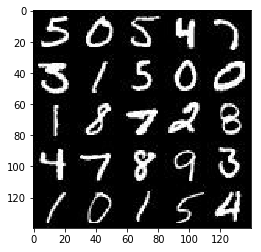

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

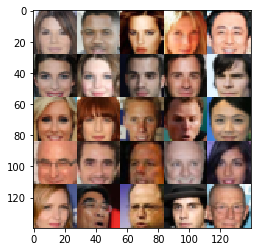

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    LearningRate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, LearningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        '''
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 3x3x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 3*3*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        '''

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        '''
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 6x6x256? now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 12x12x128? now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 24x24x3? now
        '''
            
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now

        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                #Rescaling images from (-0.5,0.5) to (-1,1)
                batch_images = batch_images * 2

                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:                
                    show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)
           

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/0... Discriminator Loss: 1.9195... Generator Loss: 0.2564
Epoch 1/0... Discriminator Loss: 1.2645... Generator Loss: 0.6034
Epoch 1/0... Discriminator Loss: 1.5875... Generator Loss: 0.5239
Epoch 1/0... Discriminator Loss: 1.2088... Generator Loss: 0.7959
Epoch 1/0... Discriminator Loss: 1.2052... Generator Loss: 0.6717
Epoch 1/0... Discriminator Loss: 1.2893... Generator Loss: 0.8843
Epoch 1/0... Discriminator Loss: 1.1830... Generator Loss: 0.9997
Epoch 1/0... Discriminator Loss: 1.1318... Generator Loss: 1.1131
Epoch 1/0... Discriminator Loss: 1.2479... Generator Loss: 1.2058
Epoch 1/0... Discriminator Loss: 1.3165... Generator Loss: 0.4963


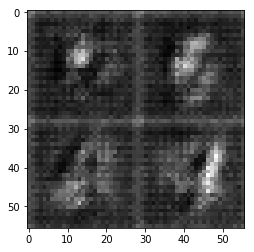

Epoch 1/0... Discriminator Loss: 1.1629... Generator Loss: 0.8953
Epoch 1/0... Discriminator Loss: 1.2291... Generator Loss: 0.6167
Epoch 1/0... Discriminator Loss: 1.1966... Generator Loss: 0.8491
Epoch 1/0... Discriminator Loss: 1.2491... Generator Loss: 0.5818
Epoch 1/0... Discriminator Loss: 1.1868... Generator Loss: 1.0501
Epoch 1/0... Discriminator Loss: 1.1765... Generator Loss: 0.7251
Epoch 1/0... Discriminator Loss: 1.1532... Generator Loss: 1.0681
Epoch 1/0... Discriminator Loss: 1.1358... Generator Loss: 0.8170
Epoch 1/0... Discriminator Loss: 1.2465... Generator Loss: 0.4957
Epoch 1/0... Discriminator Loss: 1.2166... Generator Loss: 1.1830


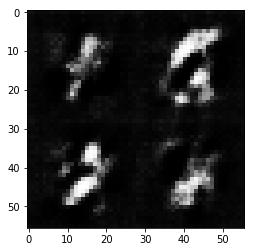

Epoch 1/0... Discriminator Loss: 1.1877... Generator Loss: 1.0252
Epoch 1/0... Discriminator Loss: 1.2896... Generator Loss: 1.2082
Epoch 1/0... Discriminator Loss: 1.1611... Generator Loss: 0.9714
Epoch 1/0... Discriminator Loss: 1.0899... Generator Loss: 1.1225
Epoch 1/0... Discriminator Loss: 1.1153... Generator Loss: 0.6736
Epoch 1/0... Discriminator Loss: 1.1019... Generator Loss: 0.8170
Epoch 1/0... Discriminator Loss: 1.0808... Generator Loss: 0.7121
Epoch 1/0... Discriminator Loss: 1.1032... Generator Loss: 1.1521
Epoch 1/0... Discriminator Loss: 1.1116... Generator Loss: 0.7376
Epoch 1/0... Discriminator Loss: 1.0366... Generator Loss: 0.7607


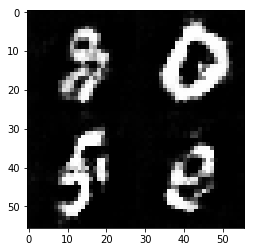

Epoch 1/0... Discriminator Loss: 1.0614... Generator Loss: 0.6717
Epoch 1/0... Discriminator Loss: 0.9675... Generator Loss: 0.8393
Epoch 1/0... Discriminator Loss: 1.0752... Generator Loss: 1.4955
Epoch 1/0... Discriminator Loss: 1.1077... Generator Loss: 1.0248
Epoch 1/0... Discriminator Loss: 1.0275... Generator Loss: 1.5092
Epoch 1/0... Discriminator Loss: 0.8940... Generator Loss: 0.9881
Epoch 1/0... Discriminator Loss: 0.8462... Generator Loss: 0.9710
Epoch 1/0... Discriminator Loss: 0.9427... Generator Loss: 0.9203
Epoch 1/0... Discriminator Loss: 1.0038... Generator Loss: 1.1258
Epoch 1/0... Discriminator Loss: 0.9678... Generator Loss: 0.7609


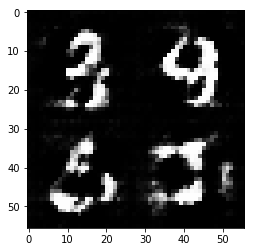

Epoch 1/0... Discriminator Loss: 0.8850... Generator Loss: 1.1465
Epoch 1/0... Discriminator Loss: 0.9977... Generator Loss: 1.5143
Epoch 1/0... Discriminator Loss: 0.9110... Generator Loss: 1.1509
Epoch 1/0... Discriminator Loss: 0.9428... Generator Loss: 0.8936
Epoch 1/0... Discriminator Loss: 0.9497... Generator Loss: 1.0259
Epoch 1/0... Discriminator Loss: 0.9566... Generator Loss: 1.3606
Epoch 2/1... Discriminator Loss: 1.1007... Generator Loss: 0.6653
Epoch 2/1... Discriminator Loss: 0.9848... Generator Loss: 1.0246
Epoch 2/1... Discriminator Loss: 0.9571... Generator Loss: 1.1961
Epoch 2/1... Discriminator Loss: 0.9962... Generator Loss: 1.1046


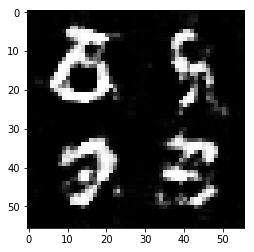

Epoch 2/1... Discriminator Loss: 1.0354... Generator Loss: 0.6706
Epoch 2/1... Discriminator Loss: 0.9975... Generator Loss: 0.7838
Epoch 2/1... Discriminator Loss: 1.1849... Generator Loss: 1.4534
Epoch 2/1... Discriminator Loss: 1.0214... Generator Loss: 1.4629
Epoch 2/1... Discriminator Loss: 0.9858... Generator Loss: 0.9978
Epoch 2/1... Discriminator Loss: 1.0467... Generator Loss: 0.7190
Epoch 2/1... Discriminator Loss: 0.9806... Generator Loss: 1.0454
Epoch 2/1... Discriminator Loss: 1.1974... Generator Loss: 1.5519
Epoch 2/1... Discriminator Loss: 1.1192... Generator Loss: 0.6578
Epoch 2/1... Discriminator Loss: 1.0239... Generator Loss: 0.7231


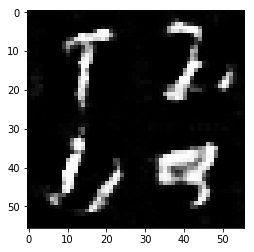

Epoch 2/1... Discriminator Loss: 1.0598... Generator Loss: 0.7484
Epoch 2/1... Discriminator Loss: 1.0544... Generator Loss: 1.2812
Epoch 2/1... Discriminator Loss: 1.1595... Generator Loss: 0.5839
Epoch 2/1... Discriminator Loss: 1.2176... Generator Loss: 1.3143
Epoch 2/1... Discriminator Loss: 1.0860... Generator Loss: 0.7187
Epoch 2/1... Discriminator Loss: 1.0872... Generator Loss: 0.8405
Epoch 2/1... Discriminator Loss: 1.2725... Generator Loss: 1.5403
Epoch 2/1... Discriminator Loss: 1.0983... Generator Loss: 0.6990
Epoch 2/1... Discriminator Loss: 1.2364... Generator Loss: 0.4783
Epoch 2/1... Discriminator Loss: 1.1245... Generator Loss: 1.1918


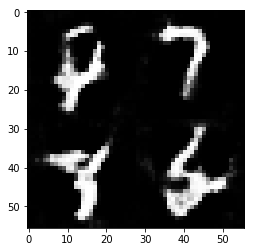

Epoch 2/1... Discriminator Loss: 1.1497... Generator Loss: 0.6143
Epoch 2/1... Discriminator Loss: 1.1024... Generator Loss: 1.2275
Epoch 2/1... Discriminator Loss: 1.0743... Generator Loss: 0.7933
Epoch 2/1... Discriminator Loss: 1.0894... Generator Loss: 0.8052
Epoch 2/1... Discriminator Loss: 1.2288... Generator Loss: 0.5439
Epoch 2/1... Discriminator Loss: 1.2286... Generator Loss: 0.5268
Epoch 2/1... Discriminator Loss: 1.0273... Generator Loss: 0.9102
Epoch 2/1... Discriminator Loss: 1.1608... Generator Loss: 0.6211
Epoch 2/1... Discriminator Loss: 1.0709... Generator Loss: 1.2092
Epoch 2/1... Discriminator Loss: 1.2332... Generator Loss: 0.5589


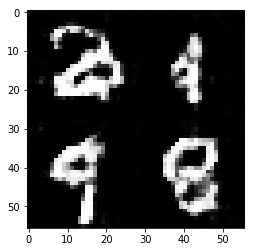

Epoch 2/1... Discriminator Loss: 1.1127... Generator Loss: 0.7238
Epoch 2/1... Discriminator Loss: 1.0949... Generator Loss: 1.0850
Epoch 2/1... Discriminator Loss: 1.0865... Generator Loss: 0.7515
Epoch 2/1... Discriminator Loss: 1.0770... Generator Loss: 0.7137
Epoch 2/1... Discriminator Loss: 1.0265... Generator Loss: 1.1127
Epoch 2/1... Discriminator Loss: 1.1089... Generator Loss: 1.0478
Epoch 2/1... Discriminator Loss: 1.0966... Generator Loss: 1.1646
Epoch 2/1... Discriminator Loss: 1.0464... Generator Loss: 0.8858
Epoch 2/1... Discriminator Loss: 1.0874... Generator Loss: 0.7822
Epoch 2/1... Discriminator Loss: 1.0622... Generator Loss: 0.8087


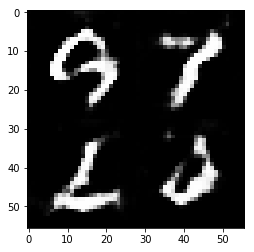

Epoch 2/1... Discriminator Loss: 1.0585... Generator Loss: 0.6969
Epoch 2/1... Discriminator Loss: 1.0934... Generator Loss: 0.9123
Epoch 2/1... Discriminator Loss: 1.0237... Generator Loss: 0.8590


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/0... Discriminator Loss: 2.4854... Generator Loss: 0.1818
Epoch 1/0... Discriminator Loss: 2.2496... Generator Loss: 0.2508
Epoch 1/0... Discriminator Loss: 1.9358... Generator Loss: 0.5073
Epoch 1/0... Discriminator Loss: 1.7577... Generator Loss: 0.6103
Epoch 1/0... Discriminator Loss: 1.6070... Generator Loss: 0.6792
Epoch 1/0... Discriminator Loss: 1.2701... Generator Loss: 0.9163
Epoch 1/0... Discriminator Loss: 1.5446... Generator Loss: 0.7214
Epoch 1/0... Discriminator Loss: 1.4390... Generator Loss: 0.7964
Epoch 1/0... Discriminator Loss: 1.3156... Generator Loss: 0.7718
Epoch 1/0... Discriminator Loss: 1.5003... Generator Loss: 0.6660


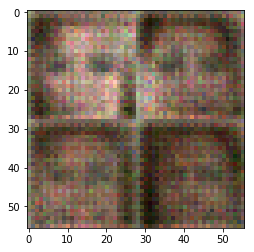

Epoch 1/0... Discriminator Loss: 1.5052... Generator Loss: 0.6503
Epoch 1/0... Discriminator Loss: 1.5290... Generator Loss: 0.7911
Epoch 1/0... Discriminator Loss: 1.4053... Generator Loss: 0.5985
Epoch 1/0... Discriminator Loss: 1.3532... Generator Loss: 0.8121
Epoch 1/0... Discriminator Loss: 1.3119... Generator Loss: 0.8058
Epoch 1/0... Discriminator Loss: 1.3984... Generator Loss: 0.7527
Epoch 1/0... Discriminator Loss: 1.3417... Generator Loss: 1.0403
Epoch 1/0... Discriminator Loss: 1.4230... Generator Loss: 0.6024
Epoch 1/0... Discriminator Loss: 1.4354... Generator Loss: 0.6857
Epoch 1/0... Discriminator Loss: 1.4307... Generator Loss: 0.6656


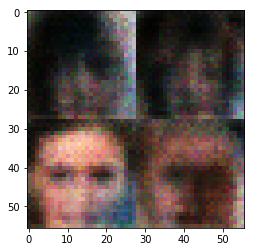

Epoch 1/0... Discriminator Loss: 1.5050... Generator Loss: 0.7701
Epoch 1/0... Discriminator Loss: 1.3997... Generator Loss: 0.9524
Epoch 1/0... Discriminator Loss: 1.4026... Generator Loss: 0.5569
Epoch 1/0... Discriminator Loss: 1.3828... Generator Loss: 0.6793
Epoch 1/0... Discriminator Loss: 1.4021... Generator Loss: 0.4910
Epoch 1/0... Discriminator Loss: 1.3288... Generator Loss: 1.5837
Epoch 1/0... Discriminator Loss: 1.1238... Generator Loss: 0.9236
Epoch 1/0... Discriminator Loss: 1.4344... Generator Loss: 0.6391
Epoch 1/0... Discriminator Loss: 1.2085... Generator Loss: 0.6671
Epoch 1/0... Discriminator Loss: 1.3561... Generator Loss: 1.4050


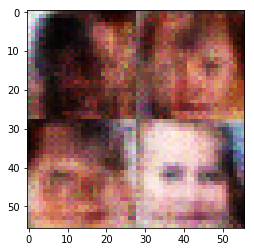

Epoch 1/0... Discriminator Loss: 1.2817... Generator Loss: 0.8509
Epoch 1/0... Discriminator Loss: 1.5463... Generator Loss: 1.4107
Epoch 1/0... Discriminator Loss: 1.1810... Generator Loss: 0.8009
Epoch 1/0... Discriminator Loss: 1.6013... Generator Loss: 0.5877
Epoch 1/0... Discriminator Loss: 1.5899... Generator Loss: 0.5041
Epoch 1/0... Discriminator Loss: 1.0615... Generator Loss: 0.9261
Epoch 1/0... Discriminator Loss: 1.3828... Generator Loss: 0.7927
Epoch 1/0... Discriminator Loss: 1.2236... Generator Loss: 1.0655
Epoch 1/0... Discriminator Loss: 1.3481... Generator Loss: 0.5589
Epoch 1/0... Discriminator Loss: 1.4953... Generator Loss: 0.5541


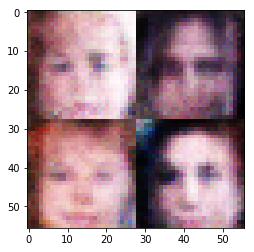

Epoch 1/0... Discriminator Loss: 1.0306... Generator Loss: 0.8580
Epoch 1/0... Discriminator Loss: 1.3519... Generator Loss: 0.6591
Epoch 1/0... Discriminator Loss: 1.1798... Generator Loss: 0.9067
Epoch 1/0... Discriminator Loss: 1.2386... Generator Loss: 0.7440
Epoch 1/0... Discriminator Loss: 1.1248... Generator Loss: 1.0188
Epoch 1/0... Discriminator Loss: 1.2299... Generator Loss: 1.0566
Epoch 1/0... Discriminator Loss: 1.4319... Generator Loss: 0.4321
Epoch 1/0... Discriminator Loss: 1.0887... Generator Loss: 0.8531
Epoch 1/0... Discriminator Loss: 0.9755... Generator Loss: 1.0472
Epoch 1/0... Discriminator Loss: 1.2438... Generator Loss: 0.8510


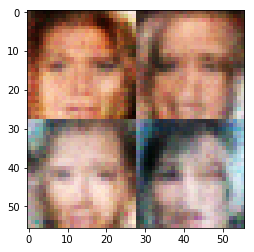

Epoch 1/0... Discriminator Loss: 1.0375... Generator Loss: 1.4786
Epoch 1/0... Discriminator Loss: 0.9042... Generator Loss: 1.1198
Epoch 1/0... Discriminator Loss: 1.0128... Generator Loss: 1.0441
Epoch 1/0... Discriminator Loss: 1.1876... Generator Loss: 2.1698
Epoch 1/0... Discriminator Loss: 1.2380... Generator Loss: 1.8428
Epoch 1/0... Discriminator Loss: 1.0149... Generator Loss: 0.8068
Epoch 1/0... Discriminator Loss: 0.8760... Generator Loss: 0.9943
Epoch 1/0... Discriminator Loss: 1.3326... Generator Loss: 0.7538
Epoch 1/0... Discriminator Loss: 1.1260... Generator Loss: 1.3779
Epoch 1/0... Discriminator Loss: 1.0721... Generator Loss: 0.8469


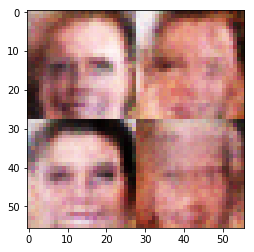

Epoch 1/0... Discriminator Loss: 1.1676... Generator Loss: 0.7845
Epoch 1/0... Discriminator Loss: 1.0144... Generator Loss: 1.3749
Epoch 1/0... Discriminator Loss: 1.4142... Generator Loss: 0.4575
Epoch 1/0... Discriminator Loss: 1.2440... Generator Loss: 0.5362
Epoch 1/0... Discriminator Loss: 0.7893... Generator Loss: 1.3293
Epoch 1/0... Discriminator Loss: 0.9614... Generator Loss: 1.7345
Epoch 1/0... Discriminator Loss: 1.4298... Generator Loss: 0.3848
Epoch 1/0... Discriminator Loss: 0.7559... Generator Loss: 1.5379
Epoch 1/0... Discriminator Loss: 1.2098... Generator Loss: 0.8446
Epoch 1/0... Discriminator Loss: 1.8234... Generator Loss: 0.2842


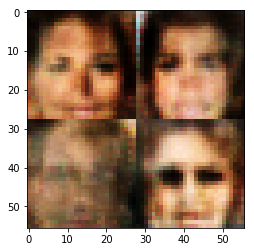

Epoch 1/0... Discriminator Loss: 1.1992... Generator Loss: 0.7684
Epoch 1/0... Discriminator Loss: 0.9598... Generator Loss: 1.1060
Epoch 1/0... Discriminator Loss: 0.9316... Generator Loss: 1.0013
Epoch 1/0... Discriminator Loss: 1.1878... Generator Loss: 1.7302
Epoch 1/0... Discriminator Loss: 1.2134... Generator Loss: 0.8220
Epoch 1/0... Discriminator Loss: 1.3879... Generator Loss: 0.6544
Epoch 1/0... Discriminator Loss: 1.0561... Generator Loss: 1.5826
Epoch 1/0... Discriminator Loss: 1.0288... Generator Loss: 2.7099
Epoch 1/0... Discriminator Loss: 1.2874... Generator Loss: 0.5634
Epoch 1/0... Discriminator Loss: 1.3554... Generator Loss: 0.5648


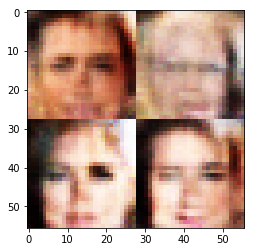

Epoch 1/0... Discriminator Loss: 1.0328... Generator Loss: 1.3015
Epoch 1/0... Discriminator Loss: 1.5203... Generator Loss: 1.8469
Epoch 1/0... Discriminator Loss: 1.3266... Generator Loss: 0.8248
Epoch 1/0... Discriminator Loss: 1.4586... Generator Loss: 0.9195
Epoch 1/0... Discriminator Loss: 1.3831... Generator Loss: 0.6982
Epoch 1/0... Discriminator Loss: 1.1559... Generator Loss: 1.2646
Epoch 1/0... Discriminator Loss: 1.0873... Generator Loss: 0.8561
Epoch 1/0... Discriminator Loss: 1.2388... Generator Loss: 0.8361
Epoch 1/0... Discriminator Loss: 1.2491... Generator Loss: 0.7738
Epoch 1/0... Discriminator Loss: 1.1653... Generator Loss: 0.7765


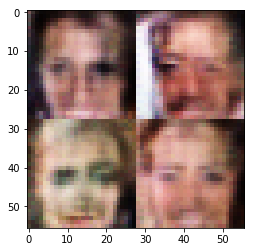

Epoch 1/0... Discriminator Loss: 1.1418... Generator Loss: 1.0153
Epoch 1/0... Discriminator Loss: 1.2161... Generator Loss: 2.0832
Epoch 1/0... Discriminator Loss: 1.2443... Generator Loss: 1.2851
Epoch 1/0... Discriminator Loss: 1.1546... Generator Loss: 1.3171
Epoch 1/0... Discriminator Loss: 1.2585... Generator Loss: 0.5918
Epoch 1/0... Discriminator Loss: 1.0868... Generator Loss: 1.3893
Epoch 1/0... Discriminator Loss: 0.9921... Generator Loss: 1.2287
Epoch 1/0... Discriminator Loss: 1.2564... Generator Loss: 1.2660
Epoch 1/0... Discriminator Loss: 1.5087... Generator Loss: 0.4039
Epoch 1/0... Discriminator Loss: 1.3915... Generator Loss: 0.5154


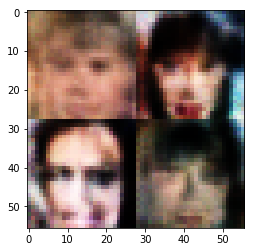

Epoch 1/0... Discriminator Loss: 1.0866... Generator Loss: 1.1130
Epoch 1/0... Discriminator Loss: 1.0201... Generator Loss: 1.6761
Epoch 1/0... Discriminator Loss: 1.0354... Generator Loss: 1.3147
Epoch 1/0... Discriminator Loss: 1.0216... Generator Loss: 1.8470
Epoch 1/0... Discriminator Loss: 1.0891... Generator Loss: 0.7950
Epoch 1/0... Discriminator Loss: 1.8358... Generator Loss: 0.2524
Epoch 1/0... Discriminator Loss: 1.6559... Generator Loss: 0.3330
Epoch 1/0... Discriminator Loss: 1.4843... Generator Loss: 0.5310
Epoch 1/0... Discriminator Loss: 1.0918... Generator Loss: 1.3808
Epoch 1/0... Discriminator Loss: 1.5300... Generator Loss: 0.3498


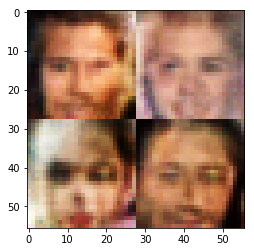

Epoch 1/0... Discriminator Loss: 1.3060... Generator Loss: 0.5466
Epoch 1/0... Discriminator Loss: 1.1555... Generator Loss: 1.2630
Epoch 1/0... Discriminator Loss: 1.2321... Generator Loss: 0.6169
Epoch 1/0... Discriminator Loss: 1.2345... Generator Loss: 1.1456
Epoch 1/0... Discriminator Loss: 1.3164... Generator Loss: 0.5426
Epoch 1/0... Discriminator Loss: 1.5462... Generator Loss: 0.4269
Epoch 1/0... Discriminator Loss: 1.1657... Generator Loss: 0.6472
Epoch 1/0... Discriminator Loss: 1.1135... Generator Loss: 0.7584
Epoch 1/0... Discriminator Loss: 1.4542... Generator Loss: 0.4685
Epoch 1/0... Discriminator Loss: 1.1768... Generator Loss: 0.6758


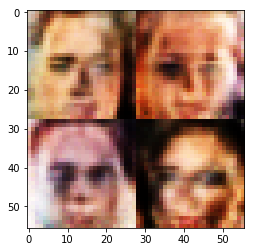

Epoch 1/0... Discriminator Loss: 0.9969... Generator Loss: 1.2288
Epoch 1/0... Discriminator Loss: 1.0558... Generator Loss: 1.1175
Epoch 1/0... Discriminator Loss: 1.3584... Generator Loss: 0.8311
Epoch 1/0... Discriminator Loss: 1.2420... Generator Loss: 1.2491
Epoch 1/0... Discriminator Loss: 1.2365... Generator Loss: 0.6595
Epoch 1/0... Discriminator Loss: 1.1868... Generator Loss: 0.7475
Epoch 1/0... Discriminator Loss: 1.1069... Generator Loss: 1.1182
Epoch 1/0... Discriminator Loss: 0.9279... Generator Loss: 2.2480
Epoch 1/0... Discriminator Loss: 1.0635... Generator Loss: 1.9158
Epoch 1/0... Discriminator Loss: 1.3473... Generator Loss: 0.5353


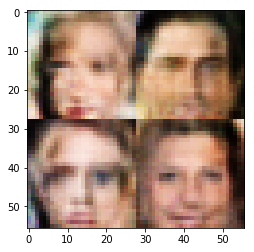

Epoch 1/0... Discriminator Loss: 1.4182... Generator Loss: 1.2292
Epoch 1/0... Discriminator Loss: 1.5298... Generator Loss: 0.4041
Epoch 1/0... Discriminator Loss: 1.0637... Generator Loss: 0.9940
Epoch 1/0... Discriminator Loss: 1.2895... Generator Loss: 0.5791
Epoch 1/0... Discriminator Loss: 0.9322... Generator Loss: 1.3134
Epoch 1/0... Discriminator Loss: 1.0549... Generator Loss: 1.4594
Epoch 1/0... Discriminator Loss: 1.1131... Generator Loss: 0.6397
Epoch 1/0... Discriminator Loss: 1.3971... Generator Loss: 0.4536
Epoch 1/0... Discriminator Loss: 0.9750... Generator Loss: 1.9942
Epoch 1/0... Discriminator Loss: 1.0708... Generator Loss: 0.9342


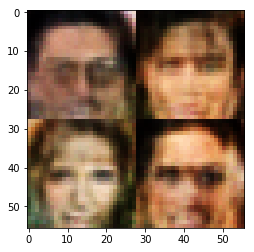

Epoch 1/0... Discriminator Loss: 0.8967... Generator Loss: 1.1637
Epoch 1/0... Discriminator Loss: 1.4222... Generator Loss: 0.4129
Epoch 1/0... Discriminator Loss: 1.2666... Generator Loss: 0.5251
Epoch 1/0... Discriminator Loss: 1.1451... Generator Loss: 0.8748
Epoch 1/0... Discriminator Loss: 0.9882... Generator Loss: 0.8701
Epoch 1/0... Discriminator Loss: 1.3198... Generator Loss: 1.2009
Epoch 1/0... Discriminator Loss: 0.9215... Generator Loss: 1.3277
Epoch 1/0... Discriminator Loss: 1.1616... Generator Loss: 1.1055
Epoch 1/0... Discriminator Loss: 1.5985... Generator Loss: 0.3495
Epoch 1/0... Discriminator Loss: 1.2574... Generator Loss: 0.5661


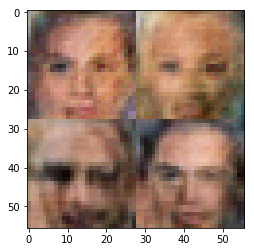

Epoch 1/0... Discriminator Loss: 1.2688... Generator Loss: 0.6595
Epoch 1/0... Discriminator Loss: 1.4635... Generator Loss: 0.8694
Epoch 1/0... Discriminator Loss: 0.9000... Generator Loss: 1.3956
Epoch 1/0... Discriminator Loss: 1.1051... Generator Loss: 1.1958
Epoch 1/0... Discriminator Loss: 1.2917... Generator Loss: 1.8665
Epoch 1/0... Discriminator Loss: 1.2214... Generator Loss: 0.6578
Epoch 1/0... Discriminator Loss: 1.3708... Generator Loss: 0.5247
Epoch 1/0... Discriminator Loss: 1.6545... Generator Loss: 0.3063


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.